In [1]:
########################################################################
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
import os
from os import listdir
from os.path import isfile, join
from sklearn import metrics
from scipy.stats import norm
import argparse
from operator import itemgetter
########################################################################
from scipy import ndimage
from numpy import array, zeros, full, argmin, inf, ndim
from scipy.spatial.distance import cdist
from math import isinf
import pandas as pd


# Density based anomaly detection for wind turbine condition monitoring

## General process to create training library (from the paper):

![Process Overview](Process.png)


### load data in list_spectrograms

The data should be available in form of spectrograms $\mathbb{R}^{f \times n}$, with $f$ being the number of frquency ranges and $n$ being the number of time steps of the spectrogram.

Text(0, 0.5, 'Frequency Ranges')

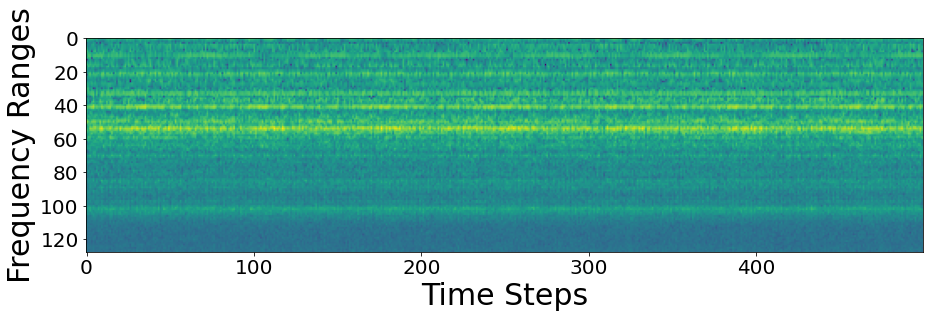

In [30]:
list_spectrograms = []

# load training spectrograms (from your training dictionary)
for i in range(1,11):
    list_spectrograms.append(np.load("Healthy/wav_files/H" + str(i) + "_AN10_freq_rep.npy"))
    
# load test spectrograms (from your test dictionary)
for i in range(1,11):
    list_spectrograms.append(np.load("Damaged/wav_files/D" + str(i) + "_AN10_freq_rep.npy"))
    
    
# visualize a spectrogram
plt.figure(figsize=[15,30])
plt.imshow(list_spectrograms[0][:,0:500])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time Steps",fontsize=30)
plt.ylabel("Frequency Ranges",fontsize=30)

### extract for all spectrograms border values for 

In [5]:
'''
extracts for a list of spectrograms the min-max value for each frequency:

output:
complete_min_matrix = minimum values for each frequency
complete_max_matrix = maximum value for each frequency
'''

# initialize min,max matrices for each condition
min_matrix = np.zeros((128, len(list_spectrograms)))
max_matrix = np.zeros((128, len(list_spectrograms)))

# extract min for each data file 
for i in range(len(list_spectrograms)):

    min_matrix[:,i] = np.min(list_spectrograms[i], axis = 1)
    max_matrix[:,i] = np.max(list_spectrograms[i], axis = 1)

min_vector = np.min(min_matrix, axis = 1)
max_vector = np.max(max_matrix, axis = 1)

### Function to sample histogram representations from spectrogram

In [6]:
def histogram_extraction(freq_rep, min_vector, max_vector, length_extracts=40, leap=15, bins_para = 8):
    '''
    -> Function to sample small frames from whole spectrogram and transform to histogram representations
    
    input:
    freq_rep: spectrogram
    min_vector: Min vector for frequencies
    max_vector: Max vector for frequencies
    length_extracts: length of the extracts
    leap: leap for extraction
    bins_para: bins for histogram representations
    
    output:
    list_extracts: list with all training extracts for the frequency_representation   
    '''
    
    # get number of frequencies
    frequencies = np.shape(freq_rep)[0]
    
    # number of data rows    
    number_columns = np.shape(freq_rep)[1]
    # number of extracts that can be retrieved
    nmbr_extracts = np.floor((number_columns-length_extracts)/leap)

    # moving average parameter (if needed - otherwise = 1)
    mov_aver = 1
    
    list_extracts = list()    
    
    for j in range(int(nmbr_extracts)):

        # calc histogram for each frequency
        histogram_freq = np.zeros((frequencies,bins_para-mov_aver+1))
        for i in range(frequencies):
            hist_raw = np.histogram(freq_rep[ i , j * leap : j* leap + length_extracts],bins=bins_para,range=(min_vector[i],max_vector[i]))
            histogram_freq[i] = hist_raw[0]
        list_extracts.append(histogram_freq)
        
    return list_extracts

### Create Training Library

Extract histogram representations that are considered as normal

In [25]:
# load normal data
list_spectrograms_train = []

for i in range(1,7):
    list_spectrograms_train.append(np.load("Healthy/wav_files/H" + str(i) + "_AN10_freq_rep.npy"))
    
# initialize list    
library_list = []

for spectrogram in list_spectrograms_train:
    
    histogram_extracts = histogram_extraction(spectrogram, min_vector, max_vector, length_extracts=40, leap=15, bins_para = 8)
    
    library_list = library_list + histogram_extracts
    


Text(0, 0.5, 'Frequency Ranges')

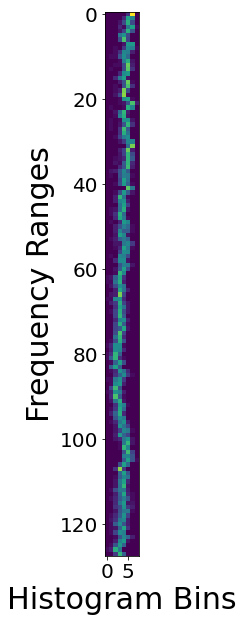

In [26]:
# visualize a histogram representation
plt.figure(figsize=[10,10])
plt.imshow(library_list[0])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Histogram Bins",fontsize=30)
plt.ylabel("Frequency Ranges",fontsize=30)

### Function to get anomaly scores for deployment spectrogram

In [27]:
def calc_anomaly_score(deployment_list, library_list):
    '''
    Function to calculate anomaly scores for a list of extracts
    
    input:
    deployment_list: list with histogram representations from test data
    library_list: list with library extracts
    
    output:
    total_result_array: array with anomaly scores
    '''

    library_array = np.asarray(library_list)
    
    # array for anomaly scores for each extract 
    total_result_array = np.zeros((len(deployment_list)))
    
    # for each element in the test list
    for i in range(len(deployment_list)):
        
        distance_array = np.sqrt(np.sum(np.sum(np.square(library_array - deployment_list[i]),axis=1),axis=1))
        
        total_result_array[i] = np.mean(np.sort(distance_array)[0:5])
        
    return total_result_array         

### Load deployment spectrogram and calculate anomaly scores

In [28]:
# load spectrogram for anomaly score calculation (from your test dictionary)
deployment_spectrogram =  np.load("Damaged/wav_files/D5_AN10_freq_rep.npy")

# get histogram representations
deployment_list = histogram_extraction(deployment_spectrogram, min_vector, max_vector, length_extracts=40, leap=15, bins_para = 8)

# get anomaly scores
anomaly_scores = calc_anomaly_score(deployment_list, library_list)

Text(0, 0.5, 'Anomaly Score')

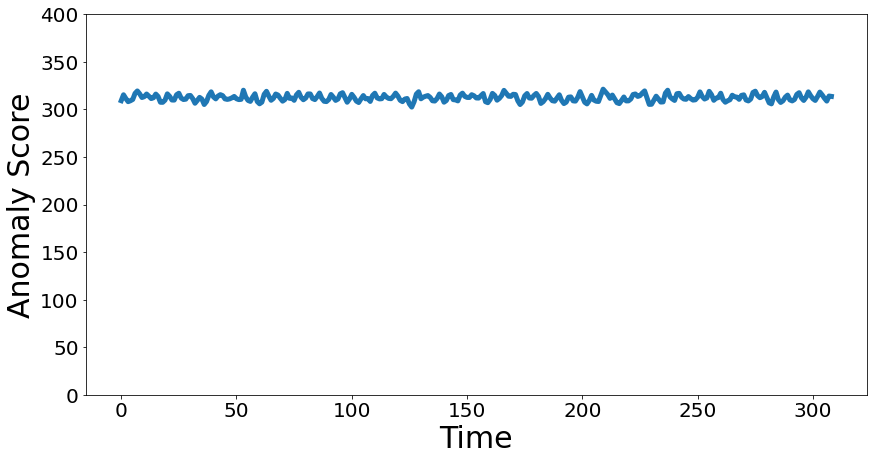

In [29]:
plt.figure(figsize=[14,7])
plt.plot(anomaly_scores,linewidth=5)
plt.ylim([0,400])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time",fontsize=30)
plt.ylabel("Anomaly Score",fontsize=30)